## Set-up

In [35]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [36]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
# MPS seems to crash every now and then
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [37]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

Loaded 45 images from /Users/peter/playground/parkbridge/images


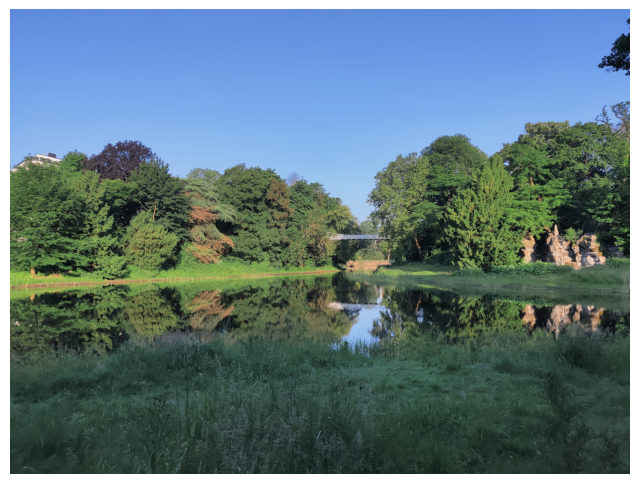

In [38]:

def downscale_image_by_percentage(image, scale_percent):
    """
    Downscale the image by a percentage while maintaining the aspect ratio.

    Args:
        image (PIL.Image or numpy.ndarray): The input image to downscale.
        scale_percent (float): The percentage to scale the image by (e.g., 50 for 50% of the original size).
    
    Returns:
        PIL.Image: The downscaled image.
    """
    # If the image is in NumPy format, convert it back to a PIL Image
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    # Calculate the new size based on the scale percentage
    width, height = image.size
    new_width = int(width * scale_percent / 100)
    new_height = int(height * scale_percent / 100)
    new_size = (new_width, new_height)
    
    # Resize the image to the new size
    downscaled_image = image.resize(new_size,  Image.Resampling.LANCZOS)
    
    return downscaled_image

def load_image(path):
    image = Image.open(path)
    image = image.convert("RGB")
    image = downscale_image_by_percentage(image, scale_percent=100)
    image = np.array(image.convert("RGB"))
    return image

def plt_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
folder_path = '/Users/peter/playground/parkbridge/images'
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
images_list = [load_image(os.path.join(folder_path, file)) for file in image_files]
print(f'Loaded {len(images_list)} images from {folder_path}')

plt_image(images_list[5])


In [39]:

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator_1 = SAM2AutomaticMaskGenerator(sam2)
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,               # points_per_side: Optional[int] = 32,
    points_per_batch=64,              # points_per_batch: int = 64,
    pred_iou_thresh=0.8,              # pred_iou_thresh: float = 0.8,
    stability_score_thresh=0.95,      # stability_score_thresh: float = 0.95,
    stability_score_offset=1.0,       # stability_score_offset: float = 1.0,
    crop_n_layers=0,                  # crop_n_layers: int = 0,
    box_nms_thresh=0.7,               # box_nms_thresh: float = 0.7,
    crop_n_points_downscale_factor=1, # crop_n_points_downscale_factor: int = 1,
    min_mask_region_area=5.0,        # min_mask_region_area: int = 0,
    use_m2m=False,                     # use_m2m: bool = False,
)

mask_generator=mask_generator_2


In [40]:
base_image_ix = image_files.index('IMG_20240820_074416.jpg')
masks_0 = mask_generator.generate(images_list[base_image_ix])


Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).


In [41]:
import numpy as np
from PIL import Image
import matplotlib.patches as patches
import math

def extract_segment_from_image(image, mask):
    """
    Extract the segment from the base image using the provided binary mask.
    
    Args:
        image (PIL.Image or numpy.ndarray): The input base image.
        mask (numpy.ndarray): The binary mask where True or 1 values represent the region to extract.
    
    Returns:
        PIL.Image: The extracted segment of the image.
    """
    # Ensure image is in NumPy array format
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # If the mask is in binary format (0, 1 or True/False), ensure it's boolean
    # mask = mask.astype(bool)

    # Create a blank image with the same size as the input image
    segment = np.zeros_like(image)
    
    # Copy the image where the mask is True (extract the segment)
    segment[mask] = image[mask]
    
    # Convert the segment back to PIL.Image format if necessary
    return Image.fromarray(segment)

def plot_segments_in_grid(image, filtered_masks):
    """
    Plots all the extracted segments from filtered masks in a grid layout.
    
    Args:
        image (PIL.Image or numpy.ndarray): The input base image.
        filtered_masks (list): A list of masks (output of SAM) containing 'segmentation' key.
        grid_size (tuple): The number of rows and columns for the grid layout.
    """
    # Create a matplotlib figure for plotting the grid
    grid_columns = 5
    grid_rows = math.ceil(len(filtered_masks) / grid_columns)
    fig, axes = plt.subplots(grid_rows, grid_columns, figsize=(5 * grid_columns, 5 * grid_rows))

    # Flatten the axes for easy indexing
    axes = axes.flatten()
    
    # Loop through the filtered masks and extract each segment
    for idx, mask in enumerate(filtered_masks):
        if idx >= grid_columns * grid_rows:
            print("More masks than grid slots. Some masks may not be displayed.")
            break
        
        # Get the segmentation mask for the current mask
        segmentation = mask['segmentation']
        
        # Extract the segment from the base image using the mask
        # extracted_segment = extract_segment_from_image(image, segmentation)
        
        # Plot the extracted segment in the grid
        # axes[idx].imshow(extracted_segment)
        axes[idx].imshow(image)
        
        # bbox
        x_min, y_min, width, height = mask['bbox']
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='red', facecolor='none')
        axes[idx].add_patch(rect)

        axes[idx].axis('off')
        axes[idx].set_title(f"Mask {idx + 1}")
    
    # Turn off any unused axes
    for ax in axes[idx + 1:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [42]:
import supervision as sv
import matplotlib.patches as patches

def mask_info(image,masks):
    print(len(masks))
    print(masks[0].keys())
    surface=image.shape[0]*image.shape[(1)]
    print([(mask['area'] / surface, mask['bbox']) for mask in sorted(masks, key=lambda x: x['area']/surface, reverse=True)])

def plot_mask(masks):
    masks_segment = [ mask['segmentation'] for mask in sorted(masks, key=lambda x: x['area'], reverse=True)]
    sv.plot_images_grid(images=masks_segment[:36], grid_size=(6, 6), size=(12, 12) )

def mask_area_filter(image,masks,min_surf=0.002, max_surf=0.15):
    surface=image.shape[0]*image.shape[(1)]
    return [m for m in masks if ((m['area'] / surface) > min_surf and (m['area'] / surface) < max_surf)]

def plot_filtered_masks(image,masks,min_surf=0.002, max_surf=0.15):
    # mask_info(image,masks)
    filtered_masks = mask_area_filter(image,masks,min_surf,max_surf)
    print(f"filtered {len(filtered_masks)}")
    mask_info(image,filtered_masks)
    # plot_segments_in_grid(image, filtered_masks) 
    
print(f"Number of images: {len(images_list)}; Number of masks: {len(masks_0)}")
for idx, image in enumerate(images_list):
    plot_filtered_masks(image, masks_0)


Number of images: 45; Number of masks: 37
filtered 20
20
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[(0.02117475, [2304.0, 847.0, 984.0, 759.0]), (0.021029833333333334, [2759.0, 848.0, 764.0, 765.0]), (0.0209735, [2758.0, 848.0, 529.0, 762.0]), (0.01882225, [1292.0, 948.0, 494.0, 645.0]), (0.015428833333333333, [2270.0, 843.0, 408.0, 707.0]), (0.011127583333333333, [3673.0, 763.0, 326.0, 726.0]), (0.007901333333333333, [691.0, 1256.0, 337.0, 410.0]), (0.006278, [2627.0, 716.0, 428.0, 275.0]), (0.006261833333333334, [2304.0, 716.0, 745.0, 543.0]), (0.006085166666666667, [297.0, 802.0, 663.0, 271.0]), (0.00600975, [439.0, 802.0, 444.0, 270.0]), (0.004590166666666667, [3464.0, 1833.0, 368.0, 247.0]), (0.0044055, [3717.0, 0.0, 282.0, 258.0]), (0.003784, [3075.0, 1515.0, 484.0, 139.0]), (0.003211, [3557.0, 1981.0, 257.0, 207.0]), (0.0029356666666666667, [3783.0, 1213.0, 216.0, 274.0]), (0.0027746666666666666, [514.0, 1053.0, 2

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2


def extract_segment_from_image(image, mask):
    """
    Extract the segment from the base image using the provided binary mask.
    The segment is cropped to its bounding box for efficient template matching.
    
    Args:
        image (numpy.ndarray): The input base image.
        mask (numpy.ndarray): The binary mask where True or 1 values represent the region to extract.
    
    Returns:
        numpy.ndarray: The cropped segment of the image.
    """
    # Ensure the mask is a boolean array
    mask = mask.astype(bool)
    
    # Find the bounding box of the mask (non-zero area)
    y_coords, x_coords = np.where(mask)
    if len(x_coords) == 0 or len(y_coords) == 0:
        raise ValueError("No mask found in the given image region.")
    
    # Get the bounding box of the mask
    x_min, x_max = x_coords.min(), x_coords.max()
    y_min, y_max = y_coords.min(), y_coords.max()
    
    # Crop the segment to this bounding box
    cropped_segment = image[y_min:y_max+1, x_min:x_max+1]

    return cropped_segment

def find_matching_segment(template, target_image):
    """
    Use cv2.matchTemplate to find the location of the segment in the target image.
    
    Args:
        template (numpy.ndarray): The extracted segment (template) from the first image.
        target_image (numpy.ndarray): The target image in which to search for the template.
    
    Returns:
        tuple: Top-left corner of the best matching region in the target image, match score.
    """
    # Convert both the template and target image to grayscale
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    target_image_gray = cv2.cvtColor(target_image, cv2.COLOR_RGB2GRAY)
    
    # Perform template matching using cv2.matchTemplate
    result = cv2.matchTemplate(target_image_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    
    # Find the location with the highest match score
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # max_loc is the top-left corner of the best match
    return max_loc, max_val

def find_matching_segment_with_distance_penalty(template, target_image, template_bbox, penalty_factor=0.1):
    """
    Use cv2.matchTemplate to find the location of the segment in the target image,
    and penalize the match score based on how far the match is from the original template's bounding box.
    
    Args:
        template (numpy.ndarray): The extracted segment (template) from the first image.
        target_image (numpy.ndarray): The target image in which to search for the template.
        template_bbox (tuple): The bounding box of the template in the format (x_min, y_min, width, height).
        penalty_factor (float): A factor to control how much distance affects the score.
    
    Returns:
        tuple: Top-left corner of the best matching region in the target image, penalized match score.
    """
    # Convert both the template and target image to grayscale
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    target_image_gray = cv2.cvtColor(target_image, cv2.COLOR_RGB2GRAY)
    
    # Perform template matching using cv2.matchTemplate
    result = cv2.matchTemplate(target_image_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    
    # Find the location with the highest match score
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # max_loc is the top-left corner of the best match
    matched_top_left = max_loc
    
    # Extract the top-left corner of the original template's bounding box
    template_top_left = (template_bbox[0], template_bbox[1])
    
    # Calculate the Euclidean distance between the matched location and the template's original location
    distance = np.linalg.norm(np.array(matched_top_left) - np.array(template_top_left))
    
    # Apply a penalty to the match score based on the distance
    penalty = 1 / (1 + penalty_factor * distance)
    penalized_score = max_val * penalty
    if(penalized_score < 0.01):
        print(f'Score:{max_val} - Penalty score:{penalized_score}. Skipping')
        return None, None
    else:
        return matched_top_left, penalized_score

def process_all_masks(image, masks, target_image):
    """
    Process all masks, extract segments from the base image, and find corresponding matching regions in the target image.
    
    Args:
        image (numpy.ndarray): The input base image.
        masks (list): List of SAM-generated mask results (each containing 'segmentation').
        target_image (numpy.ndarray): The target image to search for matching regions.
    
    Returns:
        list: List of dictionaries with information about each match.
    """
    results = []
    
    # Loop over all the masks
    for idx, mask_data in enumerate(masks):
        # Extract the segmentation mask from the mask_data
        mask = mask_data['segmentation']
        bbox = mask_data['bbox']
        # Extract the segment from the base image using the mask
        extracted_segment = extract_segment_from_image(image, mask)
        
        # Find the corresponding matching region in the target image
        # best_match_loc, match_score = find_matching_segment(extracted_segment, target_image)
        best_match_loc, match_score = find_matching_segment_with_distance_penalty(extracted_segment, target_image, bbox)
        if(best_match_loc is None):
            continue
        
        # Store the result with necessary information
        results.append({
            'mask_index': idx,
            'best_match_loc': best_match_loc,
            'match_score': match_score,
            'segment_shape': extracted_segment.shape[:2]  # Height, width of the segment
        })
    
    return results

def plot_matches_side_by_side(base_image_name, target_image_name, base_image, target_image, match_results, masks):
    """
    Plot the original base image with segments on the left and the matched segments on the target image on the right.

    Args:
        base_image (numpy.ndarray): The original base image from which segments were extracted.
        target_image (numpy.ndarray): The target image where matches were found.
        match_results (list): List of dictionaries containing match information for each mask.
        masks (list): List of SAM-generated masks (with 'segmentation' and 'bbox').
    """
    # Create a copy of both images for displaying
    base_image_copy = base_image.copy()
    target_image_copy = target_image.copy()
    
    # Create a matplotlib figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the base image with segment outlines on the left
    axes[0].imshow(base_image_copy)
    axes[0].set_title(f"Original {base_image_name} with Segments")
    
    # Plot the target image with match rectangles on the right
    axes[1].imshow(target_image_copy)
    axes[1].set_title(f"Matched Segments on {target_image_name}")
    
    # Loop through the match results and draw bounding boxes for both images
    for idx, (result, mask_data) in enumerate(zip(match_results, masks)):
        # Extract the original mask and bounding box (for the base image)
        mask_bbox = mask_data['bbox']
        x_min, y_min, width, height = mask_bbox
        
        # Draw rectangle and index in the center of the segment in the base image
        rect_base = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        axes[0].add_patch(rect_base)
        
        # Calculate center of the bounding box
        center_x_base = x_min + width / 2
        center_y_base = y_min + height / 2
        
        # Add index in the center of the base image's bounding box
        axes[0].text(center_x_base, center_y_base, str(idx), color='white', fontsize=12, ha='center', va='center')

        # Draw rectangles around the best match location on the target image
        top_left = result['best_match_loc']
        h, w = result['segment_shape']  # Height and width of the segment
        rect_target = patches.Rectangle(top_left, w, h, linewidth=2, edgecolor='green', facecolor='none')
        axes[1].add_patch(rect_target)
        
        # Calculate center of the bounding box on the target image
        center_x_target = top_left[0] + w / 2
        center_y_target = top_left[1] + h / 2
        
        # Add index in the center of the target image's bounding box
        axes[1].text(center_x_target, center_y_target, str(idx), color='white', fontsize=12, ha='center', va='center')
    
    # Hide axis ticks for both subplots
    axes[0].axis('off')
    axes[1].axis('off')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
def plot_matches_and_warped_side_by_side(base_image_name, target_image_name, base_image, target_image, warped_image, match_results, masks):
    """
    Plot the original base image with segments on the left and the matched segments on the target image on the right.

    Args:
        base_image (numpy.ndarray): The original base image from which segments were extracted.
        target_image (numpy.ndarray): The target image where matches were found.
        match_results (list): List of dictionaries containing match information for each mask.
        masks (list): List of SAM-generated masks (with 'segmentation' and 'bbox').
    """
    # Create a copy of both images for displaying
    base_image_copy = base_image.copy()
    target_image_copy = target_image.copy()
    warped_image_copy = warped_image.copy()
    # Create a matplotlib figure with three subplots (side by side)
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))
    
    # Plot the base image with segment outlines on the left
    axes[0].imshow(base_image_copy)
    axes[0].set_title(f"Original {base_image_name} with Segments")
    
    # Plot the target image with match rectangles 
    axes[1].imshow(target_image_copy)
    axes[1].set_title(f"Matched Segments on {target_image_name}")
    
    # Plot the warped image on the right
    axes[2].imshow(warped_image_copy)
    axes[2].set_title(f"Warped {target_image_name}")
    
    # Loop through the match results and draw bounding boxes for both images
    for idx, (result, mask_data) in enumerate(zip(match_results, masks)):
        # Extract the original mask and bounding box (for the base image)
        mask_bbox = mask_data['bbox']
        x_min, y_min, width, height = mask_bbox
        
        # Draw rectangle and index in the center of the segment in the base image
        rect_base = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        axes[0].add_patch(rect_base)
        
        # Calculate center of the bounding box
        center_x_base = x_min + width / 2
        center_y_base = y_min + height / 2
        
        # Add index in the center of the base image's bounding box
        axes[0].text(center_x_base, center_y_base, str(idx), color='white', fontsize=12, ha='center', va='center')

        # Draw rectangles around the best match location on the target image
        top_left = result['best_match_loc']
        h, w = result['segment_shape']  # Height and width of the segment
        rect_target = patches.Rectangle(top_left, w, h, linewidth=2, edgecolor='green', facecolor='none')
        axes[1].add_patch(rect_target)
        
        # Calculate center of the bounding box on the target image
        center_x_target = top_left[0] + w / 2
        center_y_target = top_left[1] + h / 2
        
        # Add index in the center of the target image's bounding box
        axes[1].text(center_x_target, center_y_target, str(idx), color='white', fontsize=12, ha='center', va='center')
    
    # Hide axis ticks
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()    
            

In [55]:
import cv2
import numpy as np

def calculate_bounding_box_center(bbox):
    """
    Calculate the center of a bounding box.
    
    Args:
        bbox (tuple): Bounding box in the format (x_min, y_min, width, height).
    
    Returns:
        tuple: Center point (x, y) of the bounding box.
    """
    x_min, y_min, width, height = bbox
    center_x = x_min + width / 2
    center_y = y_min + height / 2
    return center_x, center_y

def calculate_homography(template_bboxes, target_bboxes):
    """
    Calculate the homography matrix to warp the target image to match the template.
    
    Args:
        template_bboxes (list of tuples): List of bounding boxes in the template image (x_min, y_min, width, height).
        target_bboxes (list of tuples): List of bounding boxes in the target image (x_min, y_min, width, height).
    
    Returns:
        numpy.ndarray: The 3x3 homography matrix.
    """
    # Calculate the centers of the bounding boxes
    template_points = np.array([calculate_bounding_box_center(bbox) for bbox in template_bboxes])
    target_points = np.array([calculate_bounding_box_center(bbox) for bbox in target_bboxes])
    
    # Find the homography matrix using the points
    H, status = cv2.findHomography(target_points, template_points, cv2.RANSAC)
    
    return H

def warp_target_image(target_image, homography_matrix, template_image_size):
    """
    Warp the target image using the homography matrix.
    
    Args:
        target_image (numpy.ndarray): The target image to be warped.
        homography_matrix (numpy.ndarray): The 3x3 homography matrix.
        template_image_size (tuple): The size of the template image (width, height).
    
    Returns:
        numpy.ndarray: The warped target image.
    """
    # Warp the target image to align with the template
    warped_image = cv2.warpPerspective(target_image, homography_matrix, template_image_size)
    
    return warped_image

def align_images_using_homography(base_image, target_image, match_results, masks):
    """
    Align the target image to the base image using homography based on matched bounding boxes.
    
    Args:
        base_image (numpy.ndarray): The base image (template).
        target_image (numpy.ndarray): The target image to be warped.
        match_results (list): List of dictionaries containing match information for each mask.
        masks (list): List of SAM-generated masks (with 'bbox' key).
    
    Returns:
        numpy.ndarray: The warped target image.
    """
    # Extract the bounding boxes from the masks and match results
    template_bboxes = [masks[result['mask_index']]['bbox'] for result in match_results]
    target_bboxes = [(result['best_match_loc'][0], result['best_match_loc'][1], result['segment_shape'][1], result['segment_shape'][0]) for result in match_results]
    print(f"Building homograph from {len(target_bboxes)} target_bboxes")
    # Calculate the homography matrix
    if(len(template_bboxes) < 4):
        print(f"Not enough matches to warp")
        return None
    H = calculate_homography(template_bboxes, target_bboxes)
    
    # Get the size of the base (template) image
    template_image_size = (base_image.shape[1], base_image.shape[0])  # (width, height)
    
    # Warp the target image to align with the base image
    warped_image = warp_target_image(target_image, H, template_image_size)
    
    return warped_image

In [66]:
import cv2

def match_segments(image,masks,target_image,min_segment_area=0.0015,max_segment_area=0.20):
    filtered_masks = mask_area_filter(image, masks, min_segment_area, max_segment_area)
    results = process_all_masks(image, filtered_masks, target_image)
    return results,filtered_masks

def match_and_plot_segments(base_image_name,target_image_name, image,masks,target_image,min_segment_area=0.0015,max_segment_area=0.20):
    filtered_masks = mask_area_filter(image, masks, min_segment_area, max_segment_area)
    results = process_all_masks(image, filtered_masks, target_image)
    plot_matches_side_by_side(base_image_name,target_image_name, image, target_image, results, filtered_masks)
    return results,filtered_masks

def match_warp_and_plot_segments(base_image_name, target_image_name, base_image,masks,target_image,min_segment_area=0.0015,max_segment_area=0.20):
    filtered_masks = mask_area_filter(base_image, masks, min_segment_area, max_segment_area)
    results = process_all_masks(base_image, filtered_masks, target_image)
    warped_image = align_images_using_homography(base_image, target_image, results, filtered_masks)
    plot_matches_and_warped_side_by_side(base_image_name, target_image_name, base_image, target_image, warped_image, results, filtered_masks)
    return results,filtered_masks,warped_image


matched_results=[]
matched_masks=[]

images_to_warp = images_list[:len(images_list)]
# images_to_warp = images_list[:5]

# Match segments
for idx, image in enumerate(images_to_warp):
    results, masks = match_segments(images_list[base_image_ix], masks_0, image)
    matched_results.append(results)
    matched_masks.append(masks)

# Match and plot matched segments
# for idx, image in enumerate(images_to_warp):
#     results, masks = match_and_plot_segments(image_files[base_image_ix],image_files[idx], images_list[base_image_ix], masks_0, image)
#     matched_results.append(results)
#     # matched_top_masks.append(masks)
#     matched_masks.append(masks)


# Match and warp and plot matched segments and warped image
# for idx, image in enumerate(images_to_warp):
#     print(f"Working on {image_files[idx]}")
#     results, masks, warped_image = match_warp_and_plot_segments(image_files[base_image_ix],image_files[idx],  images_list[base_image_ix], masks_0, image)
#     matched_results.append(results)
#     matched_masks.append(masks)
#     if(warped_image is not None):
#         warped_image_bgr = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
#         cv2.imwrite(f'/tmp/{image_files[idx]}', warped_image_bgr)   
#     else:
#         print(f"Cant't warp {image_files[idx]}")


Score:0.5961982607841492 - Penalty score:0.0014779573929045327. Skipping
Score:0.3331611156463623 - Penalty score:0.0027200846683986175. Skipping
Score:0.4014592170715332 - Penalty score:0.005431114999452419. Skipping
Score:0.2878435254096985 - Penalty score:0.00175299745881303. Skipping
Score:0.6083660125732422 - Penalty score:0.0042992075041334305. Skipping
Score:0.3656312823295593 - Penalty score:0.0029381162517332785. Skipping
Score:0.3155035376548767 - Penalty score:0.0011352429761387513. Skipping
Score:0.7816631197929382 - Penalty score:0.0034479204500967612. Skipping
Score:0.23496752977371216 - Penalty score:0.0017049856928231172. Skipping
Score:0.7922472953796387 - Penalty score:0.008504288857014333. Skipping
Score:0.42668038606643677 - Penalty score:0.0016067603117912593. Skipping
Score:0.49729275703430176 - Penalty score:0.0026684417831052687. Skipping
Score:0.4962252080440521 - Penalty score:0.00627070651165104. Skipping
Score:0.3936477303504944 - Penalty score:0.00128888458

In [90]:
import matplotlib.pyplot as plt
import piexif
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont

def crop_center(image, crop_width, crop_height):
    """Crops the image from the center with given width and height."""
    img_width, img_height = image.size
    left = (img_width - crop_width) // 2
    top = (img_height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    return image.crop((left, top, right, bottom))

def add_timestamp_from_exif(orig_image_path,image):
    # Timestamp from exif
    orig_image = Image.open(orig_image_path)
    exif_data = piexif.load(orig_image.info.get('exif', b''))
    exif_datetime = exif_data.get('Exif', {}).get(piexif.ExifIFD.DateTimeOriginal)
    if exif_datetime:
        dt = datetime.strptime(exif_datetime.decode('utf-8'), '%Y:%m:%d %H:%M:%S')
        timestamp_str = dt.strftime('%d-%b %H:%M')

        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(rgb_image)

        draw = ImageDraw.Draw(image)
        font_path = "/Library/Fonts/PTSans-Regular.ttf"
        font_size = 40
        font = ImageFont.truetype(font_path, font_size)
        img_width, img_height = image.size
        text_position = (img_width // 2, 80)  # Top center, 12 pixels from the top
        draw.text(text_position, timestamp_str, font=font, fill=(255, 255, 255), anchor="ms")
        return image
    else:
        print('No exif datatime for')
        return image

##
for ix, image in enumerate(images_to_warp):
    warped_image = align_images_using_homography(images_list[base_image_ix], images_list[ix], matched_results[ix], matched_masks[ix])
    if(warped_image is not None):
        rgb_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_image)
        cropped_img = crop_center(pil_image, 3000, 1800)
        opencv_cropped_img = np.array(cropped_img)
        # opencv_cropped_img_bgr = cv2.cvtColor(opencv_cropped_img, cv2.COLOR_RGB2BGR)
        opencv_cropped_img_bgr = opencv_cropped_img
        final_img = add_timestamp_from_exif(f"images/{image_files[ix]}", opencv_cropped_img_bgr)
        # cv2.imwrite(f'/tmp/{image_files[ix]}', final_img)
        final_img.save(f'/tmp/{image_files[ix]}')
    else:
        print(f"Cant't warp {image_files[ix]}")

Building homograph from 6 target_bboxes
Building homograph from 15 target_bboxes
Building homograph from 16 target_bboxes
Building homograph from 11 target_bboxes
Building homograph from 15 target_bboxes
Building homograph from 16 target_bboxes
Building homograph from 10 target_bboxes
Building homograph from 15 target_bboxes
Building homograph from 7 target_bboxes
Building homograph from 14 target_bboxes
Building homograph from 12 target_bboxes
Building homograph from 15 target_bboxes
Building homograph from 13 target_bboxes
Building homograph from 15 target_bboxes
Building homograph from 15 target_bboxes
Building homograph from 17 target_bboxes
Building homograph from 16 target_bboxes
Building homograph from 16 target_bboxes
Building homograph from 12 target_bboxes
Building homograph from 17 target_bboxes
Building homograph from 16 target_bboxes
Building homograph from 13 target_bboxes
Building homograph from 16 target_bboxes
Building homograph from 15 target_bboxes
Building homograph

In [91]:
import cv2
import numpy as np
import os
import subprocess

def create_stop_motion_movie(input_folder, output_file, frame_duration=2, transition_duration=1, fps=30):
    # Get all jpg files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.jpg')]
    image_files.sort()  # Sort the files to ensure correct order

    # Get the dimensions of the first image
    first_image = cv2.imread(os.path.join(input_folder, image_files[0]))
    height, width = first_image.shape[:2]

    # Create a temporary video file
    temp_output = 'temp_output.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(temp_output, fourcc, fps, (width, height))

    for i in range(len(image_files)):
        current_img = cv2.imread(os.path.join(input_folder, image_files[i]))
        next_img = cv2.imread(os.path.join(input_folder, image_files[(i + 1) % len(image_files)]))
        
        # Hold the current image
        for _ in range(fps * frame_duration):
            out.write(current_img)
        
        # Cross-fade to the next image
        for j in range(int(fps * transition_duration)):
            alpha = j / (fps * transition_duration)
            blended = cv2.addWeighted(current_img, 1 - alpha, next_img, alpha, 0)
            out.write(blended)

    out.release()

    # Use FFmpeg to convert the temporary video to the final output with improved compression
    ffmpeg_cmd = [
        'ffmpeg',
        '-i', temp_output,
        '-c:v', 'libx264',
        '-preset', 'slow',
        '-crf', '23',
        '-vf', f'scale=-2:720',  # Scale to 720p, maintaining aspect ratio
        '-movflags', '+faststart',
        '-c:a', 'aac',
        '-b:a', '128k',
        output_file
    ]
    subprocess.run(ffmpeg_cmd, check=True)

    # Remove the temporary file
    os.remove(temp_output)

    print(f"Stop motion movie created: {output_file}")

# Usage example
input_folder = 'auto_warped'
output_file = 'auto_parkbridge.mp4'
create_stop_motion_movie(input_folder, output_file, transition_duration=0.75)

KeyboardInterrupt: 

Show all the masks overlayed on the image.

In [ ]:
def plot_overlayed(image,masks):
    filtered_masks = mask_area_filter(image,masks,0.0,1.0)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_anns(filtered_masks)
    plt.axis('off')
    plt.show() 

ix=10
plot_overlayed(images_list[base_image_ix],masks_0)


